# Re run a few models to fix for calendar length

In [1]:
import sys
sys.path.append('../')  # import functions to make life easier
import climate_xr_funcs
import climate_droughts_xr_funcs

# import things
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import regionmask
import os
# import salem
from dask.diagnostics import ProgressBar

from scipy import stats

import xesmf as xe

In [2]:
# %% set file path to model output
filepath = '/Volumes/LaCie/CMIP5-PMIP3/CESM-LME/mon/PRECT_v6/'
filepath_pmip3 = '/Volumes/LaCie/CMIP5-PMIP3'
filepath_cesm_mon = '/Volumes/LaCie/CMIP5-PMIP3/CESM-LME/mon'

In [3]:
# some options for running
process_cesm_fullforcing_files = False
process_cesm_singleforcing_files = False

process_all_pmip3_files = False

subset_pmip3_hist_files_to_Aus_only = False
subset_lme_ff_hist_files_to_Aus_only = False
subset_lme_single_forcing_hist_files_to_Aus_only = True
subset_pmip3_lm_files_to_Aus_only = False
subset_lme_ff_lm_files_to_Aus_only = False
subset_lme_single_forcing_lm_files_to_Aus_only = True

process_awap = False

regrid_awap_to_model_res = False

# ---- set output directories etc
historical_year = 1900
hist_output_dir = '../files/historical_1900'

# climatology for lm files
lm_threshold_startyear = 1900
lm_threshold_endyear = 2000

lm_output_dir = '../files/lastmillennium_threshold_1900-2000'


In [4]:
# apply drought metrics
def droughts_historical_fromyear(ds, historical_year, output_dir, model_filename):
    print('... Calculating drought metrics for %s from %s onwards' % (model_filename, historical_year))
    ds_hist = ds.where(ds['year'] >= historical_year, drop=True)    # subset to historical period
    ds_hist = ds_hist.where(ds_hist['year'] <= 2000, drop=True)  # clip to 2000 for everything
    ds_hist_clim = ds_hist.where(ds_hist['year'] <= 2000, drop=True)  # for historical, use up to 2000 for climatology
    # get years that are drought vs not drought
    ds_hist['drought_years_2s2e']       = climate_droughts_xr_funcs.get_drought_years_2S2E_apply(ds_hist.PRECT_mm, ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['drought_years_median']     = climate_droughts_xr_funcs.get_drought_years_below_threshold_apply(ds_hist.PRECT_mm, ds_hist_clim.PRECT_mm.quantile(0.5, dim=('year')))
    ds_hist['drought_years_20perc']     = climate_droughts_xr_funcs.get_drought_years_below_threshold_apply(ds_hist.PRECT_mm, ds_hist_clim.PRECT_mm.quantile(0.2, dim=('year')))
    ds_hist['drought_years_120pc_2med'] = climate_droughts_xr_funcs.get_drought_years_120perc_2median_apply(ds_hist.PRECT_mm, ds_hist_clim.PRECT_mm.quantile(0.2, dim='year'), ds_hist_clim.PRECT_mm.quantile(0.5, dim='year'))
    ds_hist['drought_years_220pc_1med'] = climate_droughts_xr_funcs.get_drought_years_start_end_thresholds_apply(ds_hist.PRECT_mm, ds_hist_clim.PRECT_mm.quantile(0.2, dim=('year')), ds_hist_clim.PRECT_mm.quantile(0.5, dim=('year')))
    
    # get overall length of droughts
    ds_hist['droughts_2s2e']       = climate_droughts_xr_funcs.cumulative_drought_length(ds_hist['drought_years_2s2e'])
    ds_hist['droughts_median']     = climate_droughts_xr_funcs.cumulative_drought_length(ds_hist['drought_years_median'])
    ds_hist['droughts_20perc']     = climate_droughts_xr_funcs.cumulative_drought_length(ds_hist['drought_years_20perc'])
    ds_hist['droughts_120pc_2med'] = climate_droughts_xr_funcs.cumulative_drought_length(ds_hist['drought_years_120pc_2med'])
    ds_hist['droughts_220pc_1med'] = climate_droughts_xr_funcs.cumulative_drought_length(ds_hist['drought_years_220pc_1med'])
    
    # get max length in this period
    ds_hist['droughts_2s2e_max']       = climate_droughts_xr_funcs.max_length_ufunc(ds_hist.droughts_2s2e, dim='year')
    ds_hist['droughts_median_max']     = climate_droughts_xr_funcs.max_length_ufunc(ds_hist.droughts_median, dim='year')
    ds_hist['droughts_20perc_max']     = climate_droughts_xr_funcs.max_length_ufunc(ds_hist.droughts_20perc, dim='year')
    ds_hist['droughts_120pc_2med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ds_hist.droughts_120pc_2med, dim='year')
    ds_hist['droughts_220pc_1med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ds_hist.droughts_220pc_1med, dim='year')
    
    # get mean length in this period
    ds_hist['droughts_2s2e_mean']       = climate_droughts_xr_funcs.mean_length_ufunc(ds_hist.droughts_2s2e, dim='year')
    ds_hist['droughts_median_mean']     = climate_droughts_xr_funcs.mean_length_ufunc(ds_hist.droughts_median, dim='year')
    ds_hist['droughts_20perc_mean']     = climate_droughts_xr_funcs.mean_length_ufunc(ds_hist.droughts_20perc, dim='year')
    ds_hist['droughts_120pc_2med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ds_hist.droughts_120pc_2med, dim='year')
    ds_hist['droughts_220pc_1med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ds_hist.droughts_220pc_1med, dim='year')
    
    # count how many individual events occur
    ds_hist['droughts_2s2e_no_of_events']       = climate_droughts_xr_funcs.count_drought_events_apply(ds_hist.droughts_2s2e)
    ds_hist['droughts_median_no_of_events']     = climate_droughts_xr_funcs.count_drought_events_apply(ds_hist.droughts_median)
    ds_hist['droughts_20perc_no_of_events']     = climate_droughts_xr_funcs.count_drought_events_apply(ds_hist.droughts_20perc)
    ds_hist['droughts_120pc_2med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events_apply(ds_hist.droughts_120pc_2med)
    ds_hist['droughts_220pc_1med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events_apply(ds_hist.droughts_220pc_1med)
    
    # std
    ds_hist['droughts_2s2e_std']       = climate_droughts_xr_funcs.std_apply(ds_hist.droughts_2s2e, dim='year')
    ds_hist['droughts_median_std']     = climate_droughts_xr_funcs.std_apply(ds_hist.droughts_median, dim='year')
    ds_hist['droughts_20perc_std']     = climate_droughts_xr_funcs.std_apply(ds_hist.droughts_20perc, dim='year')
    ds_hist['droughts_120pc_2med_std'] = climate_droughts_xr_funcs.std_apply(ds_hist.droughts_120pc_2med, dim='year')
    ds_hist['droughts_220pc_1med_std'] = climate_droughts_xr_funcs.std_apply(ds_hist.droughts_220pc_1med, dim='year')
    
    # intensity  - relative to climatological mean (same as in anna's paper)
    ds_hist['droughts_2s2e_intensity']        = climate_droughts_xr_funcs.drought_intensity(ds_hist, 'drought_years_2s2e', 'droughts_2s2e', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_median_intensity']      = climate_droughts_xr_funcs.drought_intensity(ds_hist, 'drought_years_median', 'droughts_median', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_20perc_intensity']      = climate_droughts_xr_funcs.drought_intensity(ds_hist, 'drought_years_20perc', 'droughts_20perc', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_120pc_2med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ds_hist, 'drought_years_120pc_2med', 'droughts_120pc_2med', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_220pc_1med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ds_hist, 'drought_years_220pc_1med', 'droughts_220pc_1med', ds_hist_clim.PRECT_mm.mean(dim='year'))
    
    # severity - intensity x length
    ds_hist['droughts_2s2e_severity']        = climate_droughts_xr_funcs.drought_severity(ds_hist, 'drought_years_2s2e', 'droughts_2s2e', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_median_severity']      = climate_droughts_xr_funcs.drought_severity(ds_hist, 'drought_years_median', 'droughts_median', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_20perc_severity']      = climate_droughts_xr_funcs.drought_severity(ds_hist, 'drought_years_20perc', 'droughts_20perc', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_120pc_2med_severity'] = climate_droughts_xr_funcs.drought_severity(ds_hist, 'drought_years_120pc_2med', 'droughts_120pc_2med', ds_hist_clim.PRECT_mm.mean(dim='year'))
    ds_hist['droughts_220pc_1med_severity'] = climate_droughts_xr_funcs.drought_severity(ds_hist, 'drought_years_220pc_1med', 'droughts_220pc_1med', ds_hist_clim.PRECT_mm.mean(dim='year'))
    
    # get rid of quantile
    ds_hist = ds_hist.drop('quantile')
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    comp = dict(zlib=True, complevel=8)
    encoding = {var: comp for var in ds_hist.data_vars}
    
    print('... Saving %s historical file to:  %s' % (model_filename, output_dir))
    
    delayed_obj = ds_hist.to_netcdf('%s/%s_precip_hist_annual.nc' % (output_dir, model_filename), compute=False, encoding=encoding)
    with ProgressBar():
        results = delayed_obj.compute()
    
    return ds_hist

def droughts_lm_thresholdyears(ds, threshold_startyear, threshold_endyear, output_dir, model_filename):
    print('... Calculating drought metrics for %s using %s-%s as climatology' % (model_filename, threshold_startyear, threshold_endyear))
    
    ds_lm = ds
    ds_clim = ds_lm.where((ds_lm['year'] >= threshold_startyear) & (ds_lm['year'] <= threshold_endyear), drop=True)
    ds_lm = ds_lm.where(ds_lm['year'] <= 2000, drop=True)  # clip to 2000 for everything

    # get years that are drought vs not drought
    ds_lm['drought_years_2s2e']       = climate_droughts_xr_funcs.get_drought_years_2S2E_apply(ds_lm.PRECT_mm, ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['drought_years_median']     = climate_droughts_xr_funcs.get_drought_years_below_threshold_apply(ds_lm.PRECT_mm, ds_clim.PRECT_mm.quantile(0.5, dim=('year')))
    ds_lm['drought_years_20perc']     = climate_droughts_xr_funcs.get_drought_years_below_threshold_apply(ds_lm.PRECT_mm, ds_clim.PRECT_mm.quantile(0.2, dim=('year')))
    ds_lm['drought_years_120pc_2med'] = climate_droughts_xr_funcs.get_drought_years_120perc_2median_apply(ds_lm.PRECT_mm, ds_clim.PRECT_mm.quantile(0.2, dim='year'), ds_clim.PRECT_mm.quantile(0.5, dim='year'))
    ds_lm['drought_years_220pc_1med'] = climate_droughts_xr_funcs.get_drought_years_start_end_thresholds_apply(ds_lm.PRECT_mm, ds_clim.PRECT_mm.quantile(0.2, dim=('year')), ds_clim.PRECT_mm.quantile(0.5, dim=('year')))
    
    # get overall length of droughts
    ds_lm['droughts_2s2e']       = climate_droughts_xr_funcs.cumulative_drought_length(ds_lm['drought_years_2s2e'])
    ds_lm['droughts_median']     = climate_droughts_xr_funcs.cumulative_drought_length(ds_lm['drought_years_median'])
    ds_lm['droughts_20perc']     = climate_droughts_xr_funcs.cumulative_drought_length(ds_lm['drought_years_20perc'])
    ds_lm['droughts_120pc_2med'] = climate_droughts_xr_funcs.cumulative_drought_length(ds_lm['drought_years_120pc_2med'])
    ds_lm['droughts_220pc_1med'] = climate_droughts_xr_funcs.cumulative_drought_length(ds_lm['drought_years_220pc_1med'])
    
    # get max length in this period
    ds_lm['droughts_2s2e_max']       = climate_droughts_xr_funcs.max_length_ufunc(ds_lm.droughts_2s2e, dim='year')
    ds_lm['droughts_median_max']     = climate_droughts_xr_funcs.max_length_ufunc(ds_lm.droughts_median, dim='year')
    ds_lm['droughts_20perc_max']     = climate_droughts_xr_funcs.max_length_ufunc(ds_lm.droughts_20perc, dim='year')
    ds_lm['droughts_120pc_2med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ds_lm.droughts_120pc_2med, dim='year')
    ds_lm['droughts_220pc_1med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ds_lm.droughts_220pc_1med, dim='year')
    
    # get mean length in this period
    ds_lm['droughts_2s2e_mean']       = climate_droughts_xr_funcs.mean_length_ufunc(ds_lm.droughts_2s2e, dim='year')
    ds_lm['droughts_median_mean']     = climate_droughts_xr_funcs.mean_length_ufunc(ds_lm.droughts_median, dim='year')
    ds_lm['droughts_20perc_mean']     = climate_droughts_xr_funcs.mean_length_ufunc(ds_lm.droughts_20perc, dim='year')
    ds_lm['droughts_120pc_2med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ds_lm.droughts_120pc_2med, dim='year')
    ds_lm['droughts_220pc_1med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ds_lm.droughts_220pc_1med, dim='year')
    
    # count how many individual events occur
    ds_lm['droughts_2s2e_no_of_events']       = climate_droughts_xr_funcs.count_drought_events_apply(ds_lm.droughts_2s2e)
    ds_lm['droughts_median_no_of_events']     = climate_droughts_xr_funcs.count_drought_events_apply(ds_lm.droughts_median)
    ds_lm['droughts_20perc_no_of_events']     = climate_droughts_xr_funcs.count_drought_events_apply(ds_lm.droughts_20perc)
    ds_lm['droughts_120pc_2med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events_apply(ds_lm.droughts_120pc_2med)
    ds_lm['droughts_220pc_1med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events_apply(ds_lm.droughts_220pc_1med)
    
    # std
    ds_lm['droughts_2s2e_std']       = climate_droughts_xr_funcs.std_apply(ds_lm.droughts_2s2e, dim='year')
    ds_lm['droughts_median_std']     = climate_droughts_xr_funcs.std_apply(ds_lm.droughts_median, dim='year')
    ds_lm['droughts_20perc_std']     = climate_droughts_xr_funcs.std_apply(ds_lm.droughts_20perc, dim='year')
    ds_lm['droughts_120pc_2med_std'] = climate_droughts_xr_funcs.std_apply(ds_lm.droughts_120pc_2med, dim='year')
    ds_lm['droughts_220pc_1med_std'] = climate_droughts_xr_funcs.std_apply(ds_lm.droughts_220pc_1med, dim='year')
    
    # intensity  - relative to climatological mean (same as in anna's paper)
    ds_lm['droughts_2s2e_intensity']        = climate_droughts_xr_funcs.drought_intensity(ds_lm, 'drought_years_2s2e', 'droughts_2s2e', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_median_intensity']      = climate_droughts_xr_funcs.drought_intensity(ds_lm, 'drought_years_median', 'droughts_median', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_20perc_intensity']      = climate_droughts_xr_funcs.drought_intensity(ds_lm, 'drought_years_20perc', 'droughts_20perc', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_120pc_2med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ds_lm, 'drought_years_120pc_2med', 'droughts_120pc_2med', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_220pc_1med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ds_lm, 'drought_years_220pc_1med', 'droughts_220pc_1med', ds_clim.PRECT_mm.mean(dim='year'))
    
    # severity - intensity x length
    ds_lm['droughts_2s2e_severity']        = climate_droughts_xr_funcs.drought_severity(ds_lm, 'drought_years_2s2e', 'droughts_2s2e', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_median_severity']      = climate_droughts_xr_funcs.drought_severity(ds_lm, 'drought_years_median', 'droughts_median', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_20perc_severity']      = climate_droughts_xr_funcs.drought_severity(ds_lm, 'drought_years_20perc', 'droughts_20perc', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_120pc_2med_severity'] = climate_droughts_xr_funcs.drought_severity(ds_lm, 'drought_years_120pc_2med', 'droughts_120pc_2med', ds_clim.PRECT_mm.mean(dim='year'))
    ds_lm['droughts_220pc_1med_severity'] = climate_droughts_xr_funcs.drought_severity(ds_lm, 'drought_years_220pc_1med', 'droughts_220pc_1med', ds_clim.PRECT_mm.mean(dim='year'))
    
    # get rid of quantile
    ds_lm = ds_lm.drop('quantile')
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    print('... Saving %s last millennium file to:  %s' % (model_filename, output_dir))
    comp = dict(zlib=True, complevel=8)
    encoding = {var: comp for var in ds_lm.data_vars}
    
    delayed_obj = ds_lm.to_netcdf('%s/%s_precip_lm_annual.nc' % (output_dir, model_filename), compute=False, encoding=encoding)
    with ProgressBar():
        results = delayed_obj.compute()
    
    return ds_lm


In [5]:
# Subset to Australia: using regionmask
def get_aus(ds):
    mask = regionmask.defined_regions.natural_earth.countries_110.mask(ds)
    ds_aus = ds.where(mask == 137, drop=True)
    return ds_aus


def save_netcdf_compression(ds, output_dir, filename):

    comp = dict(zlib=True, complevel=8)
    encoding = {var: comp for var in ds.data_vars}

    delayed_obj = ds.to_netcdf('%s/%s.nc' % (output_dir, filename), mode='w', compute=False, encoding=encoding)
    with ProgressBar():
        results = delayed_obj.compute()

Original PMIP3 read in def

In [6]:
def read_in_pmip3(modelname, var):
    if modelname == 'bcc':
        ds = xr.open_mfdataset('%s/past1000/%s/%s_Amon_bcc-csm1-1_past1000_r1i1p1_*.nc' % (filepath_pmip3, var, var),
                               combine='by_coords', chunks={'time': 1000})
    if modelname == 'ccsm4':
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_CCSM4_past1000_r1i1p1_085001-185012.nc' % (filepath_pmip3, var, var),
                                chunks={'time': 1000})
        ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_CCSM4_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var),
                                chunks={'time': 1000})
        ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeNoLeap(1851,1,1), drop=True)  # get rid of duplicate 1850 year
        ds_p2['lat'] = ds_p1.lat
        ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'csiro_mk3l':
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_CSIRO-Mk3L-1-2_past1000_r1i1p1_085101-185012.nc' % (filepath_pmip3, var, var), chunks={'time': 1000})
        ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_CSIRO-Mk3L-1-2_historical_r1i1p1_185101-200012.nc' % (filepath_pmip3, var, var), chunks={'time': 1000})
        ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'fgoals_gl':
        ds = xr.open_dataset('%s/past1000/%s/%s_Amon_FGOALS-gl_past1000_r1i1p1_100001-199912.nc'  % (filepath_pmip3, var, var), chunks={'time': 1000})
    if modelname == 'fgoals_s2':
        if var =='ts':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_FGOALS-s2_past1000_r1i1p1_*.nc'  % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 1000})
            ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_FGOALS-s2_historical_r1i1p1_185001-200512.nc'  % (filepath_pmip3, var, var), chunks={'time': 1000})
            ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeNoLeap(1851,1,1), drop=True)  # get rid of duplicate 1850 year
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        elif var =='pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_FGOALS-s2_past1000_r1i1p1_*.nc'  % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 1000})
            ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_FGOALS-s2_historical_r1i1p1_185001-200512.nc'  % (filepath_pmip3, var, var), chunks={'time': 1000})
            ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeNoLeap(1851,1,1), drop=True)  # get rid of duplicate 1850 year
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_FGOALS-s2_past1000_r1i1p1_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 1000})
            ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_FGOALS-s2_historical_r1i1p1_185001-200512.nc'  % (filepath_pmip3, var, var), chunks={'time': 1000})
            ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeNoLeap(1851,1,1), drop=True)  # get rid of duplicate 1850 year
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_21':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p121_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p121_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p121_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p121_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_22':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p122_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p122_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p122_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p122_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_23':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p123_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p123_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p123_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p123_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_24':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p124_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p124_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p124_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p124_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_25':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p125_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p125_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p125_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p125_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_26':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p126_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p126_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p126_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p126_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_27':
        if var == 'ts' or var == 'pr':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p127_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p127_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p127_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p127_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'giss_28':
        if var == 'ts' or var == 'pr' or var == 'psl':
            ds_p1 = xr.open_mfdataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p128_*.nc'  % (filepath_pmip3, var, var),  combine='by_coords', chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p128_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
        else:
            ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_GISS-E2-R_past1000_r1i1p128_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
            ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_GISS-E2-R_historical_r1i1p128_*.nc' % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
            ds = xr.concat([ds_p1, ds_p2], dim='time')
    if modelname == 'hadcm3':
        print('Friendly reminder that hadcm3 is missing years 1801-1859...')
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_HadCM3_past1000_r1i1p1_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
        ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_HadCM3_historical_r1i1p1_*.nc'  % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
        ds = xr.concat([ds_p1, ds_p2], dim='time')
        # something weird is happening with the time field, re-read it to be consistent just in case
        new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
        attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
        dates = xr.Dataset({'time': ('time', new_times, attrs)})
        dates = xr.decode_cf(dates)
        # ds.update({'time':('time', dates['time'], attrs)})
        ds['time'] = dates['time']

    if modelname == 'ipsl':
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_IPSL-CM5A-LR_past1000_r1i1p1_085001-185012.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_IPSL-CM5A-LR_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeNoLeap(1851,1,1), drop=True)  # get rid of duplicate 1850 year
        ds = xr.concat([ds_p1, ds_p2], dim='time')

        # something weird is happening with the time field, re-read it to be consistent just in case
        new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
        attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
        dates = xr.Dataset({'time': ('time', new_times, attrs)})
        dates = xr.decode_cf(dates)
        # ds.update({'time':('time', dates['time'], attrs)})
        ds['time'] = dates['time']

    if modelname == 'miroc':
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_MIROC-ESM_past1000_r1i1p1_085001-184912.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_MIROC-ESM_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds = xr.concat([ds_p1, ds_p2], dim='time')

        # fix times
        new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
        attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
        dates = xr.Dataset({'time': ('time', new_times, attrs)})
        dates = xr.decode_cf(dates)
        # ds.update({'time':('time', dates['time'], attrs)})
        ds['time'] = dates['time']

    if modelname == 'mpi':
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_MPI-ESM-P_past1000_r1i1p1_085001-184912.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds = xr.concat([ds_p1, ds_p2], dim='time')

        # fix times
        new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
        attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
        dates = xr.Dataset({'time': ('time', new_times, attrs)})
        dates = xr.decode_cf(dates)
        # ds.update({'time':('time', dates['time'], attrs)})
        ds['time'] = dates['time']

    if modelname == 'mri':
        ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_MRI-CGCM3_past1000_r1i1p1_085001-185012.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
        ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_MRI-CGCM3_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600}, decode_times=False)
        # try and fix the times...
        newdates = cftime.num2date(ds_p2.time.values, 'days since 1850-01-01',  calendar='standard')
        attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}# does this make sense?
        dates = xr.Dataset({'time': ('time', newdates, attrs)})
        # dates = xr.decode_cf(dates)
        # ds_p2.update({'time':('time', dates['time'], attrs)})
        ds_p2['time'] = dates['time']

        ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeGregorian(1851,1,1), drop=True)
        ds = xr.concat([ds_p1, ds_p2], dim='time')

        # fix times again
        new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
        attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
        dates = xr.Dataset({'time': ('time', new_times, attrs)})
        dates = xr.decode_cf(dates)
        # ds.update({'time':('time', dates['time'], attrs)})
        ds['time'] = dates['time']        

    return ds


In [7]:
var = 'pr'

In [7]:
#     # if modelname == 'hadcm3':
#         # print('Friendly reminder that hadcm3 is missing years 1801-1859...')
# ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_HadCM3_past1000_r1i1p1_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
# ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_HadCM3_historical_r1i1p1_*.nc'  % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
# ds = xr.concat([ds_p1, ds_p2], dim='time')
# # something weird is happening with the time field, re-read it to be consistent just in case
# new_times = cftime.date2num(ds.time, calendar=ds_p1.time.dt.calendar, units='days since 850-01-01')
# attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': ds_p1.time.dt.calendar}
# dates = xr.Dataset({'time': ('time', new_times, attrs)})
# dates = xr.decode_cf(dates)
# # ds.update({'time':('time', dates['time'], attrs)})
# ds['time'] = dates['time']

In [8]:
def process_pmip3_files(ds, modelname, historical_year, hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir):
    # import monthly pmip3 and run drought workflow
    
    # convert monthly to annual
    # month length is based on the calendar type of the original
    month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds.pr, calendar=ds.time.dt.calendar), coords=[ds.pr.time], name='month_length')
    ds['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first
    
    print(ds)
    print(month_length)
    ds_annual = ds.groupby('time.year').sum('time', skipna=False)
    ds_annual.load()
    
    # process for historical
    ds_hist = droughts_historical_fromyear(ds_annual, historical_year, hist_output_dir, modelname)
    
    # process for lm
    ds_lm = droughts_lm_thresholdyears(ds_annual, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir, modelname)
    
    return ds_hist, ds_lm

# Re run HadCM3

In [29]:
def process_pmip3_files_annual(ds_annual, modelname, historical_year, hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir):
#     # import monthly pmip3 and run drought workflow
    
#     # convert monthly to annual
#     # month length is based on the calendar type of the original
#     month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds.pr, calendar=ds.time.dt.calendar), coords=[ds.pr.time], name='month_length')
#     ds['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first
    
#     print(ds)
#     print(month_length)
#     ds_annual = ds.groupby('time.year').sum('time', skipna=False)
#     ds_annual.load()
    
    # process for historical
    ds_hist = droughts_historical_fromyear(ds_annual, historical_year, hist_output_dir, modelname)
    
    # process for lm
    ds_lm = droughts_lm_thresholdyears(ds_annual, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir, modelname)
    
    return ds_hist, ds_lm

In [350]:
    # if modelname == 'hadcm3':
    #     print('Friendly reminder that hadcm3 is missing years 1801-1859...')
    #     ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_HadCM3_past1000_r1i1p1_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
    #     ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_HadCM3_historical_r1i1p1_*.nc'  % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
    #     ds = xr.concat([ds_p1, ds_p2], dim='time')
    #     # something weird is happening with the time field, re-read it to be consistent just in case
    #     new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
    #     attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
    #     dates = xr.Dataset({'time': ('time', new_times, attrs)})
    #     dates = xr.decode_cf(dates)
    #     # ds.update({'time':('time', dates['time'], attrs)})
    #     ds['time'] = dates['time']

In [9]:
# check the units
ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_HadCM3_past1000_r1i1p1_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600}, decode_times=False)
ds_p1.time

<xarray.DataArray 'time' (time: 12012)>
array([1.50000e+01, 4.50000e+01, 7.50000e+01, ..., 3.60285e+05, 3.60315e+05,
       3.60345e+05])
Coordinates:
  * time     (time) float64 15.0 45.0 75.0 ... 3.603e+05 3.603e+05 3.603e+05
Attributes:
    bounds:         time_bnds
    units:          days since 0850-01-01
    calendar:       360_day
    axis:           T
    long_name:      time
    standard_name:  time

In [10]:
    # if modelname == 'hadcm3':
        # print('Friendly reminder that hadcm3 is missing years 1801-1859...')
ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_HadCM3_past1000_r1i1p1_085001-185012.nc'  % (filepath_pmip3, var, var), chunks={'time': 600})
ds_p2 = xr.open_mfdataset('%s/historical/%s/%s_Amon_HadCM3_historical_r1i1p1_*.nc'  % (filepath_pmip3, var, var), combine='by_coords', chunks={'time': 600})
# ds = xr.concat([ds_p1, ds_p2], dim='time')

In [11]:
ds_p2

<xarray.Dataset>
Dimensions:    (time: 1753, bnds: 2, lat: 73, lon: 96)
Coordinates:
  * time       (time) object 1859-12-16 00:00:00 ... 2005-12-16 00:00:00
  * lat        (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon        (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(300, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(300, 73, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(300, 96, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(300, 73, 96), meta=np.ndarray>
Attributes: (12/28)
    institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
    institute_id:           MOHC
    experiment_id:          historical
    source:                 HadCM3 - Hadley Centre Coupled Model Version 3 (2...
    model_id:               HadCM3
    forcing:                GHG, Oz, SA, Sl, Vl, (GHG = CO2, N2O, CH4, CFCs)
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  HadCM3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.7.1

In [356]:
# ds.load()

Create empty time array of NaNs

In [12]:
ds_p1.time.dt.calendar

'360_day'

In [13]:
missing_times_begin = cftime.Datetime360Day(1851, 1, 16)
missing_times_begin_num = cftime.date2num(missing_times_begin, units='days since 0850-01-01', calendar=ds_p1.time.dt.calendar)

missing_times_end = cftime.Datetime360Day(1859, 11, 16)
missing_times_end_num = cftime.date2num(missing_times_end, units='days since 0850-01-01', calendar=ds_p1.time.dt.calendar)

In [14]:
missing_times = np.arange(missing_times_begin_num, missing_times_end_num + 30, 30)

In [15]:
missing_times_list = cftime.num2date(missing_times, units='days since 0850-01-01', calendar=ds_p1.time.dt.calendar)

In [16]:
len(missing_times_list)

107

Create tmp array the same size as missing times

In [17]:
ds_tmp = ds_p1
ds_tmp = ds_tmp.isel(time=np.arange(0,len(missing_times_list),1))
ds_tmp

<xarray.Dataset>
Dimensions:    (time: 107, bnds: 2, lat: 73, lon: 96)
Coordinates:
  * time       (time) object 0850-01-16 00:00:00 ... 0858-11-16 00:00:00
  * lat        (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon        (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(107, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(73, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(107, 73, 96), meta=np.ndarray>
Attributes: (12/28)
    institution:            University of Edinburgh, School of Geosciences.
    institute_id:           UOED
    experiment_id:          past1000
    source:                 HadCM3 - Hadley Centre Coupled Model Version 3 (2...
    model_id:               HadCM3
    forcing:                GHG,Oz,LU,Sl,Vl
    ...                     ...
    table_id:               Table Amon (22 March 2012) b374ceec0dfa54119e545c...
    title:                  HadCM3 model output prepared for PMIP3 last mille...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.1

In [18]:
nans = xr.zeros_like(ds_tmp.pr) * np.NaN

In [19]:
ds_tmp['pr'] = xr.zeros_like(ds_tmp.pr) * np.NaN

In [20]:
ds_tmp['time'] = missing_times_list

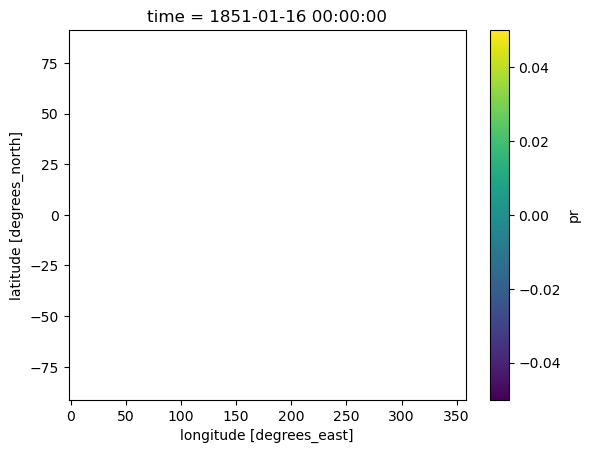

In [21]:
ds_tmp.pr[0,:,:].plot()

In [22]:
ds = xr.concat([ds_p1, ds_tmp, ds_p2], dim='time')

In [23]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds.pr, calendar=ds.time.dt.calendar), coords=[ds.pr.time], name='month_length')
ds['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first
    

In [24]:
ds.time[12000:12020]

<xarray.DataArray 'time' (time: 20)>
array([cftime.Datetime360Day(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 3, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 5, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 7, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 8, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 10, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1850, 12, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 3, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 5, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 7, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 8, 16, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 1851-08-16 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [25]:
ds_annual = ds.groupby('time.year').sum('time', skipna=False)

In [26]:
ds_annual.year[1000:1010]

<xarray.DataArray 'year' (year: 10)>
array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859

In [27]:
ds_annual.load()

<xarray.Dataset>
Dimensions:   (lat: 73, year: 1156, bnds: 2, lon: 96)
Coordinates:
  * lat       (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * year      (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 -1.08e+03 -1.065e+03 ... 1.08e+03
    lon_bnds  (year, lon, bnds) float64 -22.5 22.5 22.5 ... 4.252e+03 4.298e+03
    pr        (year, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRECT_mm  (year, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [30]:
ds_hist, ds_lm = process_pmip3_files_annual(ds_annual, 'hadcm3', historical_year, hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir)

... Calculating drought metrics for hadcm3 from 1900 onwards


/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: All-NaN slice encountered
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


... Saving hadcm3 historical file to:  ../files/historical_1900
[########################################] | 100% Completed |  0.4s
... Calculating drought metrics for hadcm3 using 1900-2000 as climatology
... Saving hadcm3 last millennium file to:  ../files/lastmillennium_threshold_1900-2000
[########################################] | 100% Completed |  0.9s


## Subset to Australia

In [32]:
ds_lm

<xarray.Dataset>
Dimensions:                           (year: 1151, lat: 73, bnds: 2, lon: 96)
Coordinates:
  * lat                               (lat) float64 -90.0 -87.5 ... 87.5 90.0
  * lon                               (lon) float64 0.0 3.75 7.5 ... 352.5 356.2
  * year                              (year) int64 850 851 852 ... 1999 2000
Dimensions without coordinates: bnds
Data variables: (12/44)
    lat_bnds                          (year, lat, bnds) float64 -1.08e+03 ......
    lon_bnds                          (year, lon, bnds) float64 -22.5 ... 4.2...
    pr                                (year, lat, lon) float32 0.0 0.0 ... 0.0
    PRECT_mm                          (year, lat, lon) float64 0.0 0.0 ... 0.0
    drought_years_2s2e                (year, lat, lon) int64 1 1 1 1 ... 1 1 1 1
    drought_years_median              (year, lat, lon) float64 1.0 1.0 ... 1.0
    ...                                ...
    droughts_220pc_1med_intensity     (year, lat, lon) float64 nan nan ... 0.0
    droughts_2s2e_severity            (year, lat, lon) float64 nan nan ... 0.0
    droughts_median_severity          (year, lat, lon) float64 nan nan ... 0.0
    droughts_20perc_severity          (year, lat, lon) float64 nan nan ... 0.0
    droughts_120pc_2med_severity      (year, lat, lon) float64 nan nan ... 0.0
    droughts_220pc_1med_severity      (year, lat, lon) float64 nan nan ... 0.0

In [35]:
hadcm3_precip_lm_annual     = xr.open_dataset('%s/hadcm3_precip_lm_annual.nc'% lm_output_dir)
hadcm3_precip_lm_annual_aus = get_aus(hadcm3_precip_lm_annual)
save_netcdf_compression(hadcm3_precip_lm_annual_aus, lm_output_dir + '/aus', 'hadcm3_precip_lm_annual_aus')

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/regionmask/defined_regions/_natural_earth.py:471: FutureWarning: ``regionmask.defined_regions.natural_earth`` is deprecated. Please use ``regionmask.defined_regions.natural_earth_v4_1_0`` or ``regionmask.defined_regions.natural_earth_v5_0_0`` instead.
  warnings.warn(


[########################################] | 100% Completed |  0.1s


In [37]:
hadcm3_precip_lm_annual

<xarray.Dataset>
Dimensions:                           (year: 1151, lat: 73, bnds: 2, lon: 96)
Coordinates:
  * lat                               (lat) float64 -90.0 -87.5 ... 87.5 90.0
  * lon                               (lon) float64 0.0 3.75 7.5 ... 352.5 356.2
  * year                              (year) int64 850 851 852 ... 1999 2000
Dimensions without coordinates: bnds
Data variables: (12/44)
    lat_bnds                          (year, lat, bnds) float64 ...
    lon_bnds                          (year, lon, bnds) float64 ...
    pr                                (year, lat, lon) float32 ...
    PRECT_mm                          (year, lat, lon) float64 ...
    drought_years_2s2e                (year, lat, lon) int64 ...
    drought_years_median              (year, lat, lon) float64 ...
    ...                                ...
    droughts_220pc_1med_intensity     (year, lat, lon) float64 ...
    droughts_2s2e_severity            (year, lat, lon) float64 ...
    droughts_median_severity          (year, lat, lon) float64 ...
    droughts_20perc_severity          (year, lat, lon) float64 ...
    droughts_120pc_2med_severity      (year, lat, lon) float64 ...
    droughts_220pc_1med_severity      (year, lat, lon) float64 ...

In [39]:
hadcm3_precip_hist_annual     = xr.open_dataset('%s/global/hadcm3_precip_hist_annual.nc' % hist_output_dir)

In [40]:
hadcm3_precip_hist_annual_aus = get_aus(hadcm3_precip_hist_annual)
save_netcdf_compression(hadcm3_precip_hist_annual_aus, hist_output_dir + '/aus', 'hadcm3_precip_hist_annual_aus')

[########################################] | 100% Completed |  0.1s


### Compare with the previously made dataset

In [41]:
hadcm3_precip_lm_annual_aus_old     = xr.open_dataset('%s/aus/hadcm3_precip_lm_annual_aus_old.nc' % lm_output_dir)

In [42]:
hadcm3_precip_lm_annual_aus

<xarray.Dataset>
Dimensions:                           (year: 1151, lat: 12, bnds: 2, lon: 10)
Coordinates:
  * lat                               (lat) float64 -42.5 -37.5 ... -15.0 -12.5
  * lon                               (lon) float64 116.2 120.0 ... 146.2 150.0
  * year                              (year) int64 850 851 852 ... 1999 2000
Dimensions without coordinates: bnds
Data variables: (12/44)
    lat_bnds                          (year, lat, bnds, lon) float64 nan ... nan
    lon_bnds                          (year, lon, bnds, lat) float64 nan ... nan
    pr                                (year, lat, lon) float32 nan nan ... nan
    PRECT_mm                          (year, lat, lon) float64 nan nan ... nan
    drought_years_2s2e                (year, lat, lon) float64 nan nan ... nan
    drought_years_median              (year, lat, lon) float64 nan nan ... nan
    ...                                ...
    droughts_220pc_1med_intensity     (year, lat, lon) float64 nan nan ... nan
    droughts_2s2e_severity            (year, lat, lon) float64 nan nan ... nan
    droughts_median_severity          (year, lat, lon) float64 nan nan ... nan
    droughts_20perc_severity          (year, lat, lon) float64 nan nan ... nan
    droughts_120pc_2med_severity      (year, lat, lon) float64 nan nan ... nan
    droughts_220pc_1med_severity      (year, lat, lon) float64 nan nan ... nan

In [45]:
hadcm3_precip_lm_annual_aus_old

<xarray.Dataset>
Dimensions:                           (year: 1151, lat: 12, bnds: 2, lon: 10)
Coordinates:
  * lat                               (lat) float64 -42.5 -37.5 ... -15.0 -12.5
  * lon                               (lon) float64 116.2 120.0 ... 146.2 150.0
  * year                              (year) int64 850 851 852 ... 1999 2000
Dimensions without coordinates: bnds
Data variables: (12/44)
    lat_bnds                          (year, lat, bnds, lon) float64 ...
    lon_bnds                          (year, lon, bnds, lat) float64 ...
    pr                                (year, lat, lon) float32 ...
    PRECT_mm                          (year, lat, lon) float64 nan nan ... nan
    drought_years_2s2e                (year, lat, lon) float64 ...
    drought_years_median              (year, lat, lon) float64 ...
    ...                                ...
    droughts_220pc_1med_intensity     (year, lat, lon) float64 ...
    droughts_2s2e_severity            (year, lat, lon) float64 ...
    droughts_median_severity          (year, lat, lon) float64 ...
    droughts_20perc_severity          (year, lat, lon) float64 ...
    droughts_120pc_2med_severity      (year, lat, lon) float64 ...
    droughts_220pc_1med_severity      (year, lat, lon) float64 ...

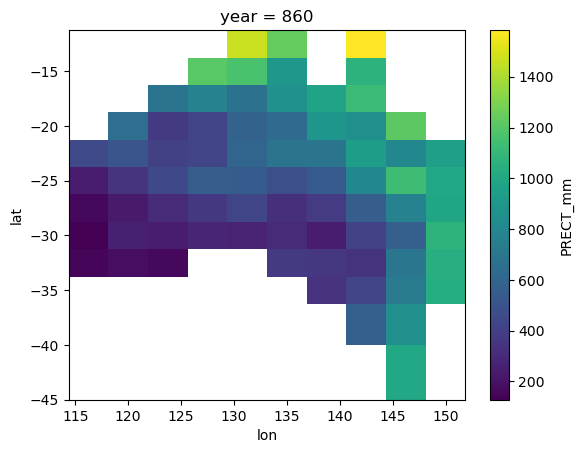

In [43]:
hadcm3_precip_lm_annual_aus_old.PRECT_mm[10,:,:].plot()

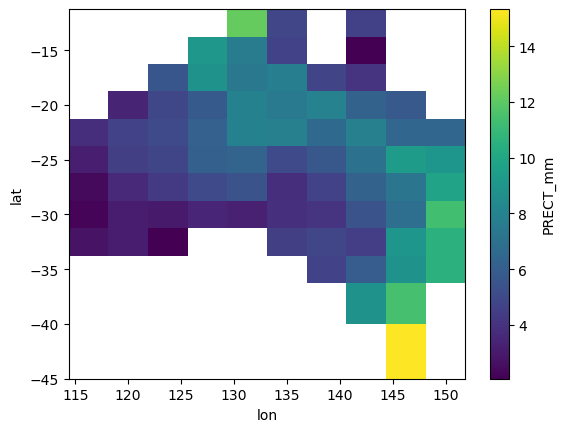

In [46]:
(hadcm3_precip_lm_annual_aus_old.PRECT_mm.mean(dim='year') - hadcm3_precip_lm_annual_aus.PRECT_mm.mean(dim='year')).plot()

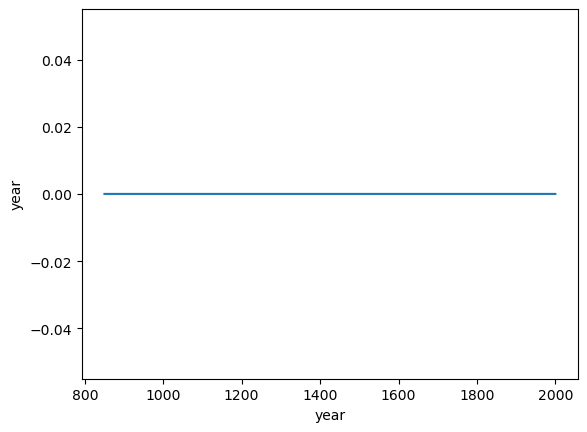

In [47]:
(hadcm3_precip_lm_annual_aus_old.year - hadcm3_precip_lm_annual_aus.year).plot()

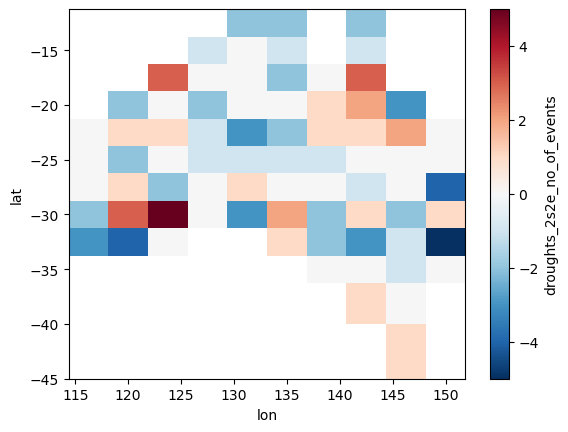

In [48]:
(hadcm3_precip_lm_annual_aus_old.droughts_2s2e_no_of_events - hadcm3_precip_lm_annual_aus.droughts_2s2e_no_of_events).plot()

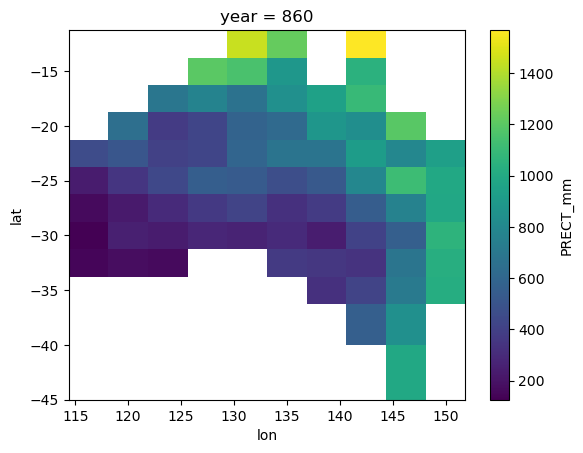

In [49]:
hadcm3_precip_lm_annual_aus.PRECT_mm[10,:,:].plot()

# Re run IPSL

In [40]:
modelname = 'ipsl'

In [46]:
if modelname == 'ipsl':
    ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_IPSL-CM5A-LR_past1000_r1i1p1_085001-185012.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
    ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_IPSL-CM5A-LR_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
    # ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeNoLeap(1851,1,1), drop=True)  # get rid of duplicate 1850 year
    ds = xr.concat([ds_p1, ds_p2], dim='time')

    # something weird is happening with the time field, re-read it to be consistent just in case
    # new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
    # attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
    # dates = xr.Dataset({'time': ('time', new_times, attrs)})
    # dates = xr.decode_cf(dates)
    # ds.update({'time':('time', dates['time'], attrs)})
    # ds['time'] = dates['time']

In [50]:
ds_p1.time.dt.calendar

'360_day'

In [51]:
ds_p2.time.dt.calendar

'noleap'

WHY WOULD YOU USE TWO DIFFERENT CALENDARS?? Manually convert to monthly, and then combine

In [97]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds_p1.pr, calendar=ds_p1.time.dt.calendar), coords=[ds_p1.pr.time], name='month_length')
ds_p1['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first

ds_p1_annual = ds_p1.groupby('time.year').sum('time', skipna=False)

In [54]:
month_length

<xarray.DataArray 'month_length' (time: 12012)>
array([30, 30, 30, ..., 30, 30, 30])
Coordinates:
  * time     (time) object 0850-01-16 00:00:00 ... 1850-12-16 00:00:00

In [55]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds_p2.pr, calendar=ds_p2.time.dt.calendar), coords=[ds_p2.pr.time], name='month_length')
ds_p2['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first

In [56]:
month_length

<xarray.DataArray 'month_length' (time: 1872)>
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00

In [60]:
ds_p1_annual = ds_p1.groupby('time.year').sum('time', skipna=False)

In [61]:
ds_p1_annual

<xarray.Dataset>
Dimensions:   (lat: 96, year: 1001, bnds: 2, lon: 96)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * year      (year) int64 850 851 852 853 854 855 ... 1846 1847 1848 1849 1850
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 96, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 96, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 96, 96), meta=np.ndarray>
    PRECT_mm  (year, lat, lon) float64 dask.array<chunksize=(1, 96, 96), meta=np.ndarray>

In [68]:
ds_p2_annual = ds_p2.groupby('time.year').sum('time', skipna=False)

In [71]:
# get rid of 1850, otherwise we will have a duplicate year
ds_p2_annual = ds_p2_annual.where(ds_p2_annual.year > 1850, drop=True)


In [72]:
ds_p2_annual

<xarray.Dataset>
Dimensions:   (year: 155, lat: 96, bnds: 2, lon: 96)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * year      (year) int64 1851 1852 1853 1854 1855 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 96, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 96, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 96, 96), meta=np.ndarray>
    PRECT_mm  (year, lat, lon) float64 dask.array<chunksize=(1, 96, 96), meta=np.ndarray>

In [73]:
ds_annual = xr.concat([ds_p1_annual, ds_p2_annual], dim='year')

In [74]:
ds_annual.load()

<xarray.Dataset>
Dimensions:   (lat: 96, year: 1156, bnds: 2, lon: 96)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * year      (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 -90.0 -89.05 -89.05 ... 89.05 89.05 90.0
    lon_bnds  (year, lon, bnds) float64 -1.875 1.875 1.875 ... 354.4 354.4 358.1
    pr        (year, lat, lon) float32 9.096e-06 9.096e-06 ... 5.768e-05
    PRECT_mm  (year, lat, lon) float64 23.58 23.58 23.58 ... 152.1 152.1 152.1

In [75]:
def process_pmip3_files_ipsl(ds_annual, modelname, historical_year, hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir):
#     # import monthly pmip3 and run drought workflow
    
#     # convert monthly to annual
#     # month length is based on the calendar type of the original
#     month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds.pr, calendar=ds.time.dt.calendar), coords=[ds.pr.time], name='month_length')
#     ds['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first
    
#     print(ds)
#     print(month_length)
#     ds_annual = ds.groupby('time.year').sum('time', skipna=False)
#     ds_annual.load()
    
    # process for historical
    ds_hist = droughts_historical_fromyear(ds_annual, historical_year, hist_output_dir, modelname)
    
    # process for lm
    ds_lm = droughts_lm_thresholdyears(ds_annual, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir, modelname)
    
    return ds_hist, ds_lm

In [78]:
process_pmip3_files_ipsl(ds_annual, modelname, historical_year, hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir)

... Calculating drought metrics for ipsl from 1900 onwards


/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: All-NaN slice encountered
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


... Saving ipsl historical file to:  ../files/historical_1900
[########################################] | 100% Completed |  0.5s
... Calculating drought metrics for ipsl using 1900-2000 as climatology
... Saving ipsl last millennium file to:  ../files/lastmillennium_threshold_1900-2000
[########################################] | 100% Completed |  0.8s


(<xarray.Dataset>
 Dimensions:                           (year: 101, lat: 96, bnds: 2, lon: 96)
 Coordinates:
   * lat                               (lat) float64 -90.0 -88.11 ... 88.11 90.0
   * lon                               (lon) float64 0.0 3.75 7.5 ... 352.5 356.2
   * year                              (year) int64 1900 1901 1902 ... 1999 2000
 Dimensions without coordinates: bnds
 Data variables: (12/44)
     lat_bnds                          (year, lat, bnds) float64 -90.0 ... 90.0
     lon_bnds                          (year, lon, bnds) float64 -1.875 ... 358.1
     pr                                (year, lat, lon) float32 5.929e-06 ... ...
     PRECT_mm                          (year, lat, lon) float64 15.65 ... 134.0
     drought_years_2s2e                (year, lat, lon) int64 1 1 1 1 ... 0 0 0 0
     drought_years_median              (year, lat, lon) float64 1.0 1.0 ... 0.0
     ...                                ...
     droughts_220pc_1med_intensity     (year, lat, lo

### Subset to Aus

In [79]:
ipsl_precip_lm_annual     = xr.open_dataset('%s/ipsl_precip_lm_annual.nc'% lm_output_dir)
ipsl_precip_lm_annual_aus = get_aus(ipsl_precip_lm_annual)
save_netcdf_compression(ipsl_precip_lm_annual_aus, lm_output_dir + '/aus', 'ipsl_precip_lm_annual_aus')

ipsl_precip_hist_annual     = xr.open_dataset('%s/global/ipsl_precip_hist_annual.nc' % hist_output_dir)
ipsl_precip_hist_annual_aus = get_aus(ipsl_precip_hist_annual)
save_netcdf_compression(ipsl_precip_hist_annual_aus, hist_output_dir + '/aus', 'ipsl_precip_hist_annual_aus')


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


# re run miroc

In [98]:
modelname = 'miroc'

if modelname == 'miroc':
    ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_MIROC-ESM_past1000_r1i1p1_085001-184912.nc' % (filepath_pmip3, var, var), chunks={'time': 600})
    ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_MIROC-ESM_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600}, use_cftime=True)
    ds = xr.concat([ds_p1, ds_p2], dim='time')

    # # fix times
    # new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
    # attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
    # dates = xr.Dataset({'time': ('time', new_times, attrs)})
    # dates = xr.decode_cf(dates)
    # # ds.update({'time':('time', dates['time'], attrs)})
    # ds['time'] = dates['time']

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 850-1-1. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0850-1-1). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cf

In [99]:
ds_p1.time.dt.calendar

'proleptic_gregorian'

In [100]:
ds_p2.time.dt.calendar

'standard'

In [101]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds_p1.pr, calendar=ds_p1.time.dt.calendar), coords=[ds_p1.pr.time], name='month_length')
ds_p1['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first

ds_p1_annual = ds_p1.groupby('time.year').sum('time', skipna=False)

In [104]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds_p2.pr, calendar=ds_p2.time.dt.calendar), coords=[ds_p2.pr.time], name='month_length')
ds_p2['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first

ds_p2_annual = ds_p2.groupby('time.year').sum('time', skipna=False)

In [103]:
ds_p1_annual

<xarray.Dataset>
Dimensions:   (lat: 64, year: 1000, bnds: 2, lon: 128)
Coordinates:
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * year      (year) int64 850 851 852 853 854 855 ... 1845 1846 1847 1848 1849
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 64, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 128, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 64, 128), meta=np.ndarray>
    PRECT_mm  (year, lat, lon) float64 dask.array<chunksize=(1, 64, 128), meta=np.ndarray>

In [105]:
ds_p2_annual

<xarray.Dataset>
Dimensions:   (lat: 64, year: 156, bnds: 2, lon: 128)
Coordinates:
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * year      (year) int64 1850 1851 1852 1853 1854 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 64, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 128, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 64, 128), meta=np.ndarray>
    PRECT_mm  (year, lat, lon) float64 dask.array<chunksize=(1, 64, 128), meta=np.ndarray>

In [109]:
ds_annual = xr.concat([ds_p1_annual, ds_p2_annual], dim='year')
ds_annual.load()

<xarray.Dataset>
Dimensions:   (lat: 64, year: 1156, bnds: 2, lon: 128)
Coordinates:
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * year      (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 -90.0 -86.58 -86.58 ... 86.58 86.58 90.0
    lon_bnds  (year, lon, bnds) float64 -1.406 1.406 1.406 ... 355.8 355.8 358.6
    pr        (year, lat, lon) float32 1.286e-05 1.243e-05 ... 5.927e-05
    PRECT_mm  (year, lat, lon) float64 33.72 32.61 31.52 ... 157.0 155.5 156.0

In [110]:
process_pmip3_files_annual(ds_annual, modelname, historical_year, 
                           hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir)

... Calculating drought metrics for miroc from 1900 onwards


/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: All-NaN slice encountered
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


... Saving miroc historical file to:  ../files/historical_1900
[########################################] | 100% Completed |  0.4s
... Calculating drought metrics for miroc using 1900-2000 as climatology
... Saving miroc last millennium file to:  ../files/lastmillennium_threshold_1900-2000
[########################################] | 100% Completed |  0.5s


(<xarray.Dataset>
 Dimensions:                           (year: 101, lat: 64, bnds: 2, lon: 128)
 Coordinates:
   * lat                               (lat) float64 -87.86 -85.1 ... 85.1 87.86
   * lon                               (lon) float64 0.0 2.812 ... 354.4 357.2
   * year                              (year) int64 1900 1901 1902 ... 1999 2000
 Dimensions without coordinates: bnds
 Data variables: (12/44)
     lat_bnds                          (year, lat, bnds) float64 -90.0 ... 90.0
     lon_bnds                          (year, lon, bnds) float64 -1.406 ... 358.6
     pr                                (year, lat, lon) float32 1.128e-05 ... ...
     PRECT_mm                          (year, lat, lon) float64 29.63 ... 165.0
     drought_years_2s2e                (year, lat, lon) int64 0 0 0 0 ... 0 0 0 0
     drought_years_median              (year, lat, lon) float64 0.0 0.0 ... 0.0
     ...                                ...
     droughts_220pc_1med_intensity     (year, lat, lon)

In [112]:
miroc_precip_lm_annual     = xr.open_dataset('%s/miroc_precip_lm_annual.nc'% lm_output_dir)
miroc_precip_lm_annual_aus = get_aus(miroc_precip_lm_annual)
save_netcdf_compression(miroc_precip_lm_annual_aus, lm_output_dir + '/aus', 'miroc_precip_lm_annual_aus')

miroc_precip_hist_annual     = xr.open_dataset('%s/global/miroc_precip_hist_annual.nc' % hist_output_dir)
miroc_precip_hist_annual_aus = get_aus(miroc_precip_hist_annual)
save_netcdf_compression(miroc_precip_hist_annual_aus, hist_output_dir + '/aus', 'miroc_precip_hist_annual_aus')


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


# re run MPI

In [119]:
modelname = 'mpi'

if modelname == 'mpi':
    ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_MPI-ESM-P_past1000_r1i1p1_085001-184912.nc' % (filepath_pmip3, var, var), chunks={'time': 600}, use_cftime=True)
    ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_MPI-ESM-P_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600}, use_cftime=True)
    ds = xr.concat([ds_p1, ds_p2], dim='time')

#     # fix times
#     new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
#     attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
#     dates = xr.Dataset({'time': ('time', new_times, attrs)})
#     dates = xr.decode_cf(dates)
#     # ds.update({'time':('time', dates['time'], attrs)})
#     ds['time'] = dates['time']

In [122]:
ds

<xarray.Dataset>
Dimensions:    (time: 13872, bnds: 2, lat: 96, lon: 192)
Coordinates:
  * time       (time) object 0850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12000, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12000, 192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 96, 192), meta=np.ndarray>
Attributes: (12/28)
    institution:            Max Planck Institute for Meteorology
    institute_id:           MPI-M
    experiment_id:          past1000
    source:                 MPI-ESM-P 2011; URL: http://svn.zmaw.de/svn/cosmo...
    model_id:               MPI-ESM-P
    forcing:                GHG, Sl, Vl, LU
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  MPI-ESM-P model output prepared for CMIP5 last mi...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.6.0

In [126]:
ds_p1.time.dt.calendar

'proleptic_gregorian'

In [127]:
ds_p2.time.dt.calendar

'proleptic_gregorian'

In [128]:
process_pmip3_files(ds, modelname, historical_year, hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir)

<xarray.Dataset>
Dimensions:    (time: 13872, bnds: 2, lat: 96, lon: 192)
Coordinates:
  * time       (time) object 0850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12000, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12000, 192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 96, 192), meta=np.ndarray>
    PRECT_mm   (time, lat, lon) float64 dask.array<chunksize=(600, 96, 192), meta=np.ndarray>
Attributes: (12/28)
    institution:            Max Planck Institute for Meteorology
    institute_id:           MPI-M
    experiment_id:          past1000
    source:  

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: All-NaN slice encountered
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


... Saving mpi historical file to:  ../files/historical_1900
[########################################] | 100% Completed |  0.8s
... Calculating drought metrics for mpi using 1900-2000 as climatology
... Saving mpi last millennium file to:  ../files/lastmillennium_threshold_1900-2000
[########################################] | 100% Completed |  0.7s


(<xarray.Dataset>
 Dimensions:                           (year: 101, lat: 96, bnds: 2, lon: 192)
 Coordinates:
   * lat                               (lat) float64 -88.57 -86.72 ... 88.57
   * lon                               (lon) float64 0.0 1.875 ... 356.2 358.1
   * year                              (year) int64 1900 1901 1902 ... 1999 2000
 Dimensions without coordinates: bnds
 Data variables: (12/44)
     lat_bnds                          (year, lat, bnds) float64 -1.08e+03 ......
     lon_bnds                          (year, lon, bnds) float64 -11.25 ... 4....
     pr                                (year, lat, lon) float32 2.62e-05 ... 0...
     PRECT_mm                          (year, lat, lon) float64 69.32 ... 274.1
     drought_years_2s2e                (year, lat, lon) int64 0 0 0 0 ... 0 0 0 0
     drought_years_median              (year, lat, lon) float64 0.0 0.0 ... 0.0
     ...                                ...
     droughts_220pc_1med_intensity     (year, lat, lon) f

In [129]:
mpi_precip_lm_annual     = xr.open_dataset('%s/mpi_precip_lm_annual.nc'% lm_output_dir)
mpi_precip_lm_annual_aus = get_aus(mpi_precip_lm_annual)
save_netcdf_compression(mpi_precip_lm_annual_aus, lm_output_dir + '/aus', 'mpi_precip_lm_annual_aus')

mpi_precip_hist_annual     = xr.open_dataset('%s/mpi_precip_hist_annual.nc' % hist_output_dir)
mpi_precip_hist_annual_aus = get_aus(mpi_precip_hist_annual)
save_netcdf_compression(mpi_precip_hist_annual_aus, hist_output_dir + '/aus', 'mpi_precip_hist_annual_aus')


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


# re run mri

In [140]:
modelname = 'mri'

if modelname == 'mri':
    ds_p1 = xr.open_dataset('%s/past1000/%s/%s_Amon_MRI-CGCM3_past1000_r1i1p1_085001-185012.nc' % (filepath_pmip3, var, var), chunks={'time': 600}, use_cftime=True)
    ds_p2 = xr.open_dataset('%s/historical/%s/%s_Amon_MRI-CGCM3_historical_r1i1p1_185001-200512.nc' % (filepath_pmip3, var, var), chunks={'time': 600}, use_cftime=True)
    # try and fix the times...
#     newdates = cftime.num2date(ds_p2.time.values, 'days since 1850-01-01',  calendar='standard')
#     attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}# does this make sense?
#     dates = xr.Dataset({'time': ('time', newdates, attrs)})
#     # dates = xr.decode_cf(dates)
#     # ds_p2.update({'time':('time', dates['time'], attrs)})
#     ds_p2['time'] = dates['time']

#     ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeGregorian(1851,1,1), drop=True)
#     ds = xr.concat([ds_p1, ds_p2], dim='time')

#     # fix times again
#     new_times = cftime.date2num(ds.time, calendar='365_day', units='days since 850-01-01')
#     attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
#     dates = xr.Dataset({'time': ('time', new_times, attrs)})
#     dates = xr.decode_cf(dates)
#     # ds.update({'time':('time', dates['time'], attrs)})
#     ds['time'] = dates['time']    

In [141]:
ds_p1.time.dt.calendar

'proleptic_gregorian'

In [148]:
ds_p2.time.dt.calendar

'standard'

In [147]:
ds_p2 = ds_p2.where(ds_p2.time >= cftime.DatetimeGregorian(1851,1,1), drop=True)

In [143]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds_p1.pr, calendar=ds_p1.time.dt.calendar), coords=[ds_p1.pr.time], name='month_length')
ds_p1['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first

ds_p1_annual = ds_p1.groupby('time.year').sum('time', skipna=False)

In [149]:
# convert monthly to annual
# month length is based on the calendar type of the original
month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds_p2.pr, calendar=ds_p2.time.dt.calendar), coords=[ds_p2.pr.time], name='month_length')
ds_p2['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first

ds_p2_annual = ds_p2.groupby('time.year').sum('time', skipna=False)

In [150]:
ds_p2.time[0:20]

<xarray.DataArray 'time' (time: 20)>
array([cftime.DatetimeGregorian(1851, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 4, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 5, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 6, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 7, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 8, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1851, 12, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 2, 15, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 4, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 5, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 6, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 7, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1852, 8, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1851-01-16 12:00:00 ... 1852-08-16 12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [151]:
ds_p1_annual

<xarray.Dataset>
Dimensions:   (lat: 160, year: 1001, bnds: 2, lon: 320)
Coordinates:
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * year      (year) int64 850 851 852 853 854 855 ... 1846 1847 1848 1849 1850
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 160, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 320, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 160, 320), meta=np.ndarray>
    PRECT_mm  (year, lat, lon) float64 dask.array<chunksize=(1, 160, 320), meta=np.ndarray>

In [152]:
ds_p2_annual

<xarray.Dataset>
Dimensions:   (year: 155, lat: 160, bnds: 2, lon: 320)
Coordinates:
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * year      (year) int64 1851 1852 1853 1854 1855 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 dask.array<chunksize=(1, 160, 2), meta=np.ndarray>
    lon_bnds  (year, lon, bnds) float64 dask.array<chunksize=(1, 320, 2), meta=np.ndarray>
    pr        (year, lat, lon) float32 dask.array<chunksize=(1, 160, 320), meta=np.ndarray>
    PRECT_mm  (year, lat, lon) float64 dask.array<chunksize=(1, 160, 320), meta=np.ndarray>

In [153]:
ds_annual = xr.concat([ds_p1_annual, ds_p2_annual], dim='year')
ds_annual.load()

<xarray.Dataset>
Dimensions:   (lat: 160, year: 1156, bnds: 2, lon: 320)
Coordinates:
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * year      (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 -90.0 -88.59 ... 1.063e+03 1.08e+03
    lon_bnds  (year, lon, bnds) float64 -0.5625 0.5625 ... 4.3e+03 4.313e+03
    pr        (year, lat, lon) float32 3.016e-05 3.019e-05 ... 8.603e-05
    PRECT_mm  (year, lat, lon) float64 79.26 79.33 79.05 ... 226.9 226.8 226.4

In [154]:
process_pmip3_files_annual(ds_annual, modelname, historical_year, 
                           hist_output_dir, lm_threshold_startyear, lm_threshold_endyear, lm_output_dir)

... Calculating drought metrics for mri from 1900 onwards


/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: All-NaN slice encountered
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: Mean of empty slice
  result_data = func(*input_data)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


... Saving mri historical file to:  ../files/historical_1900
[########################################] | 100% Completed |  0.7s
... Calculating drought metrics for mri using 1900-2000 as climatology
... Saving mri last millennium file to:  ../files/lastmillennium_threshold_1900-2000
[########################################] | 100% Completed |  0.5s


(<xarray.Dataset>
 Dimensions:                           (year: 101, lat: 160, bnds: 2, lon: 320)
 Coordinates:
   * lat                               (lat) float64 -89.14 -88.03 ... 89.14
   * lon                               (lon) float64 0.0 1.125 ... 357.8 358.9
   * year                              (year) int64 1900 1901 1902 ... 1999 2000
 Dimensions without coordinates: bnds
 Data variables: (12/44)
     lat_bnds                          (year, lat, bnds) float64 -1.08e+03 ......
     lon_bnds                          (year, lon, bnds) float64 -6.75 ... 4.3...
     pr                                (year, lat, lon) float32 3.528e-05 ... ...
     PRECT_mm                          (year, lat, lon) float64 91.94 ... 209.6
     drought_years_2s2e                (year, lat, lon) int64 0 0 0 0 ... 0 0 0 0
     drought_years_median              (year, lat, lon) float64 0.0 0.0 ... 0.0
     ...                                ...
     droughts_220pc_1med_intensity     (year, lat, lon) 

In [155]:
mri_precip_lm_annual     = xr.open_dataset('%s/mri_precip_lm_annual.nc'% lm_output_dir)
mri_precip_lm_annual_aus = get_aus(mri_precip_lm_annual)
save_netcdf_compression(mri_precip_lm_annual_aus, lm_output_dir + '/aus', 'mri_precip_lm_annual_aus')

mri_precip_hist_annual     = xr.open_dataset('%s/mri_precip_hist_annual.nc' % hist_output_dir)
mri_precip_hist_annual_aus = get_aus(mri_precip_hist_annual)
save_netcdf_compression(mri_precip_hist_annual_aus, hist_output_dir + '/aus', 'mri_precip_hist_annual_aus')


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


# Regrid files

In [50]:
def regrid_files(ds):
    # resolution of output 3°?
    #[110, 156, -45, -4
#     ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 92, 2.5)),
#                          'lon': (['lon'], np.arange(0, 360, 2.5))})
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 92, 2)),
                         'lon': (['lon'], np.arange(0, 360, 2))})
    
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=False)
#     regridder = xe.Regridder(ds, ds_out, 'bilinear')


    # regridder.clean_weight_file()
    
    ds_out = regridder(ds)
#     for k in ds.data_vars:
#         print(k, ds_out[k].equals(regridder(ds[k])))
        
    return ds_out

In [51]:
def save_netcdf_compression(ds, output_dir, filename):

    comp = dict(zlib=True, complevel=8)
    encoding = {var: comp for var in ds.data_vars}

    delayed_obj = ds.to_netcdf('%s/%s.nc' % (output_dir, filename), mode='w', compute=False, encoding=encoding)
    with ProgressBar():
        results = delayed_obj.compute()

In [52]:
# Subset to Australia: using regionmask
def get_aus(ds):
    mask = regionmask.defined_regions.natural_earth.countries_110.mask(ds)
    ds_aus = ds.where(mask == 137, drop=True)
    return ds_aus

In [53]:
input_dir = '../files'

In [54]:
def calculate_drought_sum(ds):
    ds['droughts_2s2e_sum_100yrs'] = (ds.droughts_2s2e.sum(dim='year') / len(ds.year)) * 100
    ds['droughts_2s2e_no_events_100yrs'] = (ds.droughts_2s2e_no_of_events / len(ds.year)) * 100
    
    return ds

### historical

In [55]:
historical_year = 1900
input_dir_hist = '%s/historical_%s' % (input_dir, historical_year)

In [56]:
regridded_hist_output_dir = '%s/global_2degrees' % input_dir_hist

In [57]:
regridded_hist_output_dir_aus = '%s/aus_2degrees' % input_dir_hist
if not os.path.exists(regridded_hist_output_dir_aus):
    print("... Creating %s now "  % regridded_hist_output_dir_aus)
    os.makedirs(regridded_hist_output_dir_aus)

### pmip3 files

In [58]:
hadcm3_precip_hist_annual     = xr.open_dataset('%s/global/hadcm3_precip_hist_annual.nc' % input_dir_hist)
ipsl_precip_hist_annual       = xr.open_dataset('%s/global/ipsl_precip_hist_annual.nc' % input_dir_hist)
miroc_precip_hist_annual      = xr.open_dataset('%s/global/miroc_precip_hist_annual.nc' % input_dir_hist)
mpi_precip_hist_annual        = xr.open_dataset('%s/global/mpi_precip_hist_annual.nc' % input_dir_hist)
mri_precip_hist_annual        = xr.open_dataset('%s/global/mri_precip_hist_annual.nc' % input_dir_hist)


In [59]:
hadcm3_precip_hist_annual = hadcm3_precip_hist_annual.drop(('lat_bnds', 'lon_bnds'))
ipsl_precip_hist_annual = ipsl_precip_hist_annual.drop(('lat_bnds', 'lon_bnds'))
miroc_precip_hist_annual = miroc_precip_hist_annual.drop(('lat_bnds', 'lon_bnds'))
mpi_precip_hist_annual = mpi_precip_hist_annual.drop(('lat_bnds', 'lon_bnds'))
mri_precip_hist_annual = mri_precip_hist_annual.drop(('lat_bnds', 'lon_bnds'))


In [60]:

hadcm3_precip_hist_annual  = calculate_drought_sum(hadcm3_precip_hist_annual)
ipsl_precip_hist_annual  = calculate_drought_sum(ipsl_precip_hist_annual)
miroc_precip_hist_annual  = calculate_drought_sum(miroc_precip_hist_annual)
mpi_precip_hist_annual  = calculate_drought_sum(mpi_precip_hist_annual)
mri_precip_hist_annual  = calculate_drought_sum(mri_precip_hist_annual)


In [61]:
hadcm3_precip_hist_annual_rg     = regrid_files(hadcm3_precip_hist_annual)
ipsl_precip_hist_annual_rg       = regrid_files(ipsl_precip_hist_annual)
miroc_precip_hist_annual_rg      = regrid_files(miroc_precip_hist_annual)
mpi_precip_hist_annual_rg        = regrid_files(mpi_precip_hist_annual)
mri_precip_hist_annual_rg        = regrid_files(mri_precip_hist_annual)


In [62]:
save_netcdf_compression(hadcm3_precip_hist_annual_rg, regridded_hist_output_dir, 'hadcm3_precip_hist_annual_2d')
save_netcdf_compression(ipsl_precip_hist_annual_rg, regridded_hist_output_dir, 'ipsl_precip_hist_annual_2d')
save_netcdf_compression(miroc_precip_hist_annual_rg, regridded_hist_output_dir, 'miroc_precip_hist_annual_2d')
save_netcdf_compression(mpi_precip_hist_annual_rg, regridded_hist_output_dir, 'mpi_precip_hist_annual_2d')
save_netcdf_compression(mri_precip_hist_annual_rg, regridded_hist_output_dir, 'mri_precip_hist_annual_2d')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [63]:
hadcm3_precip_hist_annual_aus_rg     = get_aus(hadcm3_precip_hist_annual_rg)
ipsl_precip_hist_annual_aus_rg       = get_aus(ipsl_precip_hist_annual_rg)
miroc_precip_hist_annual_aus_rg      = get_aus(miroc_precip_hist_annual_rg)
mpi_precip_hist_annual_aus_rg        = get_aus(mpi_precip_hist_annual_rg)
mri_precip_hist_annual_aus_rg        = get_aus(mri_precip_hist_annual_rg)


In [64]:
save_netcdf_compression(hadcm3_precip_hist_annual_aus_rg, regridded_hist_output_dir_aus, 'hadcm3_precip_hist_annual_aus_2d')
save_netcdf_compression(ipsl_precip_hist_annual_aus_rg, regridded_hist_output_dir_aus, 'ipsl_precip_hist_annual_aus_2d')
save_netcdf_compression(miroc_precip_hist_annual_aus_rg, regridded_hist_output_dir_aus, 'miroc_precip_hist_annual_aus_2d')
save_netcdf_compression(mpi_precip_hist_annual_aus_rg, regridded_hist_output_dir_aus, 'mpi_precip_hist_annual_aus_2d')
save_netcdf_compression(mri_precip_hist_annual_aus_rg, regridded_hist_output_dir_aus, 'mri_precip_hist_annual_aus_2d')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


### last millennium

In [65]:
input_dir_lm = '%s/lastmillennium_threshold_1900-2000' % (input_dir)

regridded_lm_output_dir = '%s/global_2degrees' % input_dir_lm

if not os.path.exists(regridded_lm_output_dir):
    print("... Creating %s now "  % regridded_lm_output_dir)
    os.makedirs(regridded_lm_output_dir)
    
regridded_lm_output_dir_aus = '%s/aus_2degrees' % input_dir_lm

if not os.path.exists(regridded_lm_output_dir_aus):
    print("... Creating %s now "  % regridded_lm_output_dir_aus)
    os.makedirs(regridded_lm_output_dir_aus)
    
lacie_lm = '/Volumes/LaCie/aus-droughts-last-mill/files/lastmillennium_threshold_1900-2000'

In [66]:
hadcm3_precip_lm_annual     = xr.open_dataset('%s/hadcm3_precip_lm_annual.nc' % input_dir_lm)
ipsl_precip_lm_annual       = xr.open_dataset('%s/ipsl_precip_lm_annual.nc' % input_dir_lm)
miroc_precip_lm_annual      = xr.open_dataset('%s/miroc_precip_lm_annual.nc' % input_dir_lm)
mpi_precip_lm_annual        = xr.open_dataset('%s/mpi_precip_lm_annual.nc' % input_dir_lm)
mri_precip_lm_annual        = xr.open_dataset('%s/mri_precip_lm_annual.nc' % input_dir_lm)


In [67]:
hadcm3_precip_lm_annual = hadcm3_precip_lm_annual.drop(('lat_bnds', 'lon_bnds'))
ipsl_precip_lm_annual = ipsl_precip_lm_annual.drop(('lat_bnds', 'lon_bnds'))
miroc_precip_lm_annual = miroc_precip_lm_annual.drop(('lat_bnds', 'lon_bnds'))
mpi_precip_lm_annual = mpi_precip_lm_annual.drop(('lat_bnds', 'lon_bnds'))
mri_precip_lm_annual = mri_precip_lm_annual.drop(('lat_bnds', 'lon_bnds'))


In [68]:
hadcm3_precip_lm_annual  = calculate_drought_sum(hadcm3_precip_lm_annual)
ipsl_precip_lm_annual  = calculate_drought_sum(ipsl_precip_lm_annual)
miroc_precip_lm_annual  = calculate_drought_sum(miroc_precip_lm_annual)
mpi_precip_lm_annual  = calculate_drought_sum(mpi_precip_lm_annual)
mri_precip_lm_annual  = calculate_drought_sum(mri_precip_lm_annual)


In [69]:
hadcm3_precip_lm_annual_rg     = regrid_files(hadcm3_precip_lm_annual)
ipsl_precip_lm_annual_rg       = regrid_files(ipsl_precip_lm_annual)
miroc_precip_lm_annual_rg      = regrid_files(miroc_precip_lm_annual)
mpi_precip_lm_annual_rg        = regrid_files(mpi_precip_lm_annual)
mri_precip_lm_annual_rg        = regrid_files(mri_precip_lm_annual)


In [70]:
save_netcdf_compression(hadcm3_precip_lm_annual_rg, regridded_lm_output_dir, 'hadcm3_precip_lm_annual_2d')
save_netcdf_compression(ipsl_precip_lm_annual_rg, regridded_lm_output_dir, 'ipsl_precip_lm_annual_2d')
save_netcdf_compression(miroc_precip_lm_annual_rg, regridded_lm_output_dir, 'miroc_precip_lm_annual_2d')
save_netcdf_compression(mpi_precip_lm_annual_rg, regridded_lm_output_dir, 'mpi_precip_lm_annual_2d')
save_netcdf_compression(mri_precip_lm_annual_rg, regridded_lm_output_dir, 'mri_precip_lm_annual_2d')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [71]:
hadcm3_precip_lm_annual_aus_rg     = get_aus(hadcm3_precip_lm_annual_rg)
ipsl_precip_lm_annual_aus_rg       = get_aus(ipsl_precip_lm_annual_rg)
miroc_precip_lm_annual_aus_rg      = get_aus(miroc_precip_lm_annual_rg)
mpi_precip_lm_annual_aus_rg        = get_aus(mpi_precip_lm_annual_rg)
mri_precip_lm_annual_aus_rg        = get_aus(mri_precip_lm_annual_rg)


In [72]:
save_netcdf_compression(hadcm3_precip_lm_annual_aus_rg, regridded_lm_output_dir_aus, 'hadcm3_precip_lm_annual_aus_2d')
save_netcdf_compression(ipsl_precip_lm_annual_aus_rg, regridded_lm_output_dir_aus, 'ipsl_precip_lm_annual_aus_2d')
save_netcdf_compression(miroc_precip_lm_annual_aus_rg, regridded_lm_output_dir_aus, 'miroc_precip_lm_annual_aus_2d')
save_netcdf_compression(mpi_precip_lm_annual_aus_rg, regridded_lm_output_dir_aus, 'mpi_precip_lm_annual_aus_2d')
save_netcdf_compression(mri_precip_lm_annual_aus_rg, regridded_lm_output_dir_aus, 'mri_precip_lm_annual_aus_2d')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


# Compare some annual means etc

In [73]:
hadcm3_precip_lm_annual_aus_rg_old = xr.open_dataset('%s/hadcm3_precip_lm_annual_aus_2d_old.nc' % regridded_lm_output_dir_aus)

In [74]:
hadcm3_precip_lm_annual_aus_rg = xr.open_dataset('%s/hadcm3_precip_lm_annual_aus_2d.nc' % regridded_lm_output_dir_aus)

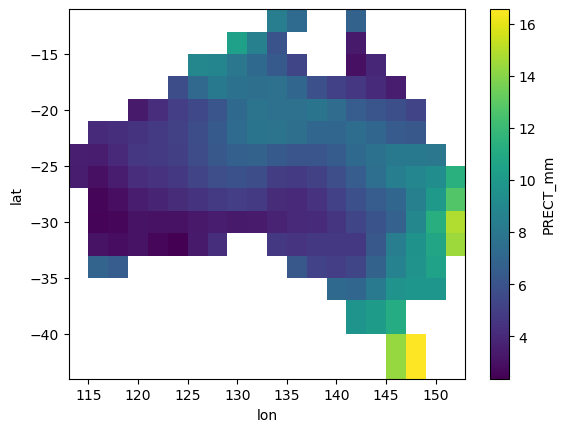

In [80]:
(hadcm3_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year') - hadcm3_precip_lm_annual_aus_rg.PRECT_mm.mean(dim='year')).plot()

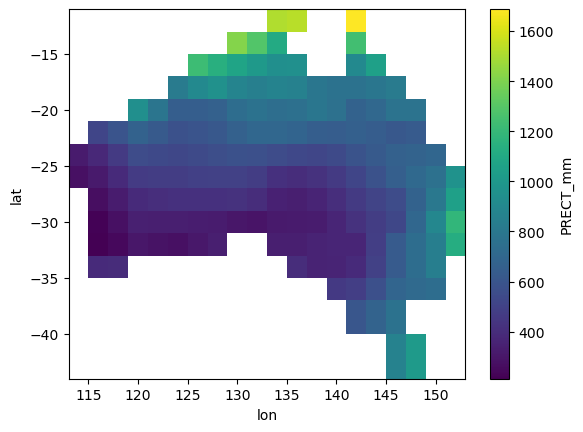

In [190]:
ipsl_precip_lm_annual_aus_rg_old = xr.open_dataset('%s/ipsl_precip_lm_annual_aus_2d_old.nc' % regridded_lm_output_dir_aus)

In [191]:
ipsl_precip_lm_annual_aus_rg_old

<xarray.Dataset>
Dimensions:                           (year: 1151, lat: 15, lon: 20)
Coordinates:
  * year                              (year) int64 850 851 852 ... 1999 2000
  * lat                               (lat) int64 -42 -38 -36 ... -16 -14 -12
  * lon                               (lon) int64 114 116 118 ... 148 150 152
Data variables: (12/44)
    pr                                (year, lat, lon) float32 ...
    PRECT_mm                          (year, lat, lon) float64 ...
    drought_years_2s2e                (year, lat, lon) float64 ...
    drought_years_median              (year, lat, lon) float64 ...
    drought_years_20perc              (year, lat, lon) float64 ...
    drought_years_120pc_2med          (year, lat, lon) float64 ...
    ...                                ...
    droughts_median_severity          (year, lat, lon) float64 ...
    droughts_20perc_severity          (year, lat, lon) float64 ...
    droughts_120pc_2med_severity      (year, lat, lon) float64 ...
    droughts_220pc_1med_severity      (year, lat, lon) float64 ...
    droughts_2s2e_sum_100yrs          (lat, lon) float64 ...
    droughts_2s2e_no_events_100yrs    (lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [192]:
ipsl_precip_lm_annual_aus_rg

<xarray.Dataset>
Dimensions:                           (year: 1151, lat: 15, lon: 20)
Coordinates:
  * year                              (year) int64 850 851 852 ... 1999 2000
  * lat                               (lat) int64 -42 -38 -36 ... -16 -14 -12
  * lon                               (lon) int64 114 116 118 ... 148 150 152
Data variables: (12/44)
    pr                                (year, lat, lon) float32 nan nan ... nan
    PRECT_mm                          (year, lat, lon) float64 nan nan ... nan
    drought_years_2s2e                (year, lat, lon) float64 nan nan ... nan
    drought_years_median              (year, lat, lon) float64 nan nan ... nan
    drought_years_20perc              (year, lat, lon) float64 nan nan ... nan
    drought_years_120pc_2med          (year, lat, lon) float64 nan nan ... nan
    ...                                ...
    droughts_median_severity          (year, lat, lon) float64 nan nan ... nan
    droughts_20perc_severity          (year, lat, lon) float64 nan nan ... nan
    droughts_120pc_2med_severity      (year, lat, lon) float64 nan nan ... nan
    droughts_220pc_1med_severity      (year, lat, lon) float64 nan nan ... nan
    droughts_2s2e_sum_100yrs          (lat, lon) float64 nan nan nan ... nan nan
    droughts_2s2e_no_events_100yrs    (lat, lon) float64 nan nan nan ... nan nan
Attributes:
    regrid_method:  bilinear

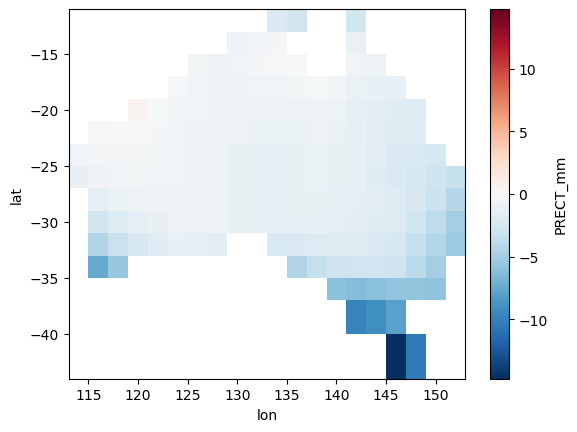

In [193]:
(ipsl_precip_lm_annual_aus_rg.PRECT_mm.mean(dim='year')  - ipsl_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

In [82]:
miroc_precip_lm_annual_aus_rg = xr.open_dataset('%s/miroc_precip_lm_annual_aus_2d.nc' % regridded_lm_output_dir_aus)

In [83]:
miroc_precip_lm_annual_aus_rg_old = xr.open_dataset('%s/miroc_precip_lm_annual_aus_2d_old.nc' % regridded_lm_output_dir_aus)

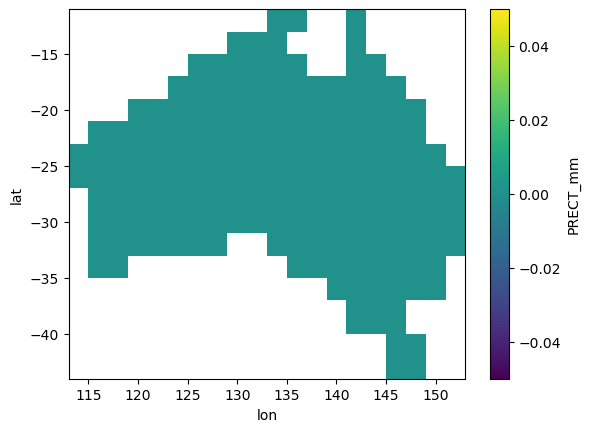

In [87]:
(miroc_precip_lm_annual_aus_rg.PRECT_mm.mean(dim='year') - miroc_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

In [88]:
mpi_precip_lm_annual_aus_rg = xr.open_dataset('%s/mpi_precip_lm_annual_aus_2d.nc' % regridded_lm_output_dir_aus)
mri_precip_lm_annual_aus_rg = xr.open_dataset('%s/mri_precip_lm_annual_aus_2d.nc' % regridded_lm_output_dir_aus)

In [89]:
mpi_precip_lm_annual_aus_rg_old = xr.open_dataset('%s/mpi_precip_lm_annual_aus_2d_old.nc' % regridded_lm_output_dir_aus)
mri_precip_lm_annual_aus_rg_old = xr.open_dataset('%s/mri_precip_lm_annual_aus_2d_old.nc' % regridded_lm_output_dir_aus)

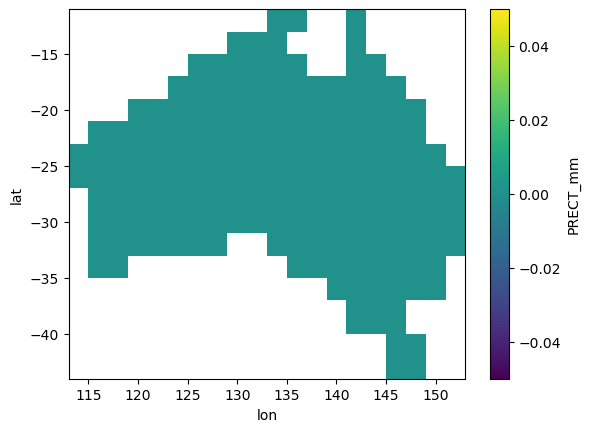

In [90]:
(mpi_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year') - mpi_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

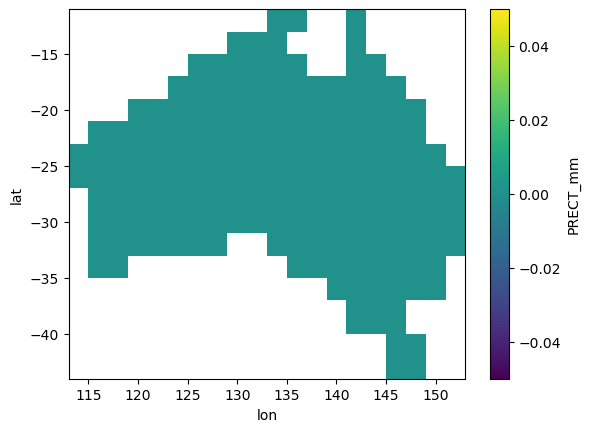

In [91]:
(mri_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year') - mri_precip_lm_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

In [92]:
hadcm3_precip_hist_annual_aus_rg = xr.open_dataset('%s/hadcm3_precip_hist_annual_aus_2d.nc' % regridded_hist_output_dir_aus)
ipsl_precip_hist_annual_aus_rg = xr.open_dataset('%s/ipsl_precip_hist_annual_aus_2d.nc' % regridded_hist_output_dir_aus)
miroc_precip_hist_annual_aus_rg = xr.open_dataset('%s/miroc_precip_hist_annual_aus_2d.nc' % regridded_hist_output_dir_aus)
mpi_precip_hist_annual_aus_rg = xr.open_dataset('%s/mpi_precip_hist_annual_aus_2d.nc' % regridded_hist_output_dir_aus)
mri_precip_hist_annual_aus_rg = xr.open_dataset('%s/mri_precip_hist_annual_aus_2d.nc' % regridded_hist_output_dir_aus)

In [93]:
hadcm3_precip_hist_annual_aus_rg_old = xr.open_dataset('%s/hadcm3_precip_hist_annual_aus_2d_old.nc' % regridded_hist_output_dir_aus)
ipsl_precip_hist_annual_aus_rg_old = xr.open_dataset('%s/ipsl_precip_hist_annual_aus_2d_old.nc' % regridded_hist_output_dir_aus)
miroc_precip_hist_annual_aus_rg_old = xr.open_dataset('%s/miroc_precip_hist_annual_aus_2d_old.nc' % regridded_hist_output_dir_aus)
mpi_precip_hist_annual_aus_rg_old = xr.open_dataset('%s/mpi_precip_hist_annual_aus_2d_old.nc' % regridded_hist_output_dir_aus)
mri_precip_hist_annual_aus_rg_old = xr.open_dataset('%s/mri_precip_hist_annual_aus_2d_old.nc' % regridded_hist_output_dir_aus)

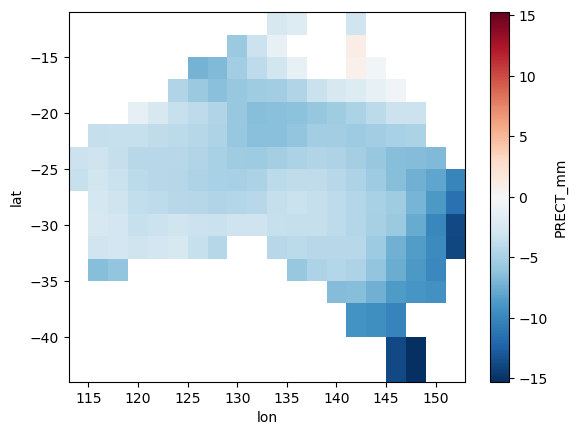

In [94]:
(hadcm3_precip_hist_annual_aus_rg.PRECT_mm.mean(dim='year') - hadcm3_precip_hist_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

In [97]:
hadcm3_precip_hist_annual_aus_rg_old

<xarray.Dataset>
Dimensions:                           (year: 101, lat: 15, lon: 20)
Coordinates:
  * year                              (year) int64 1900 1901 1902 ... 1999 2000
  * lat                               (lat) int64 -42 -38 -36 ... -16 -14 -12
  * lon                               (lon) int64 114 116 118 ... 148 150 152
Data variables: (12/44)
    pr                                (year, lat, lon) float32 ...
    PRECT_mm                          (year, lat, lon) float64 nan nan ... nan
    drought_years_2s2e                (year, lat, lon) float64 ...
    drought_years_median              (year, lat, lon) float64 ...
    drought_years_20perc              (year, lat, lon) float64 ...
    drought_years_120pc_2med          (year, lat, lon) float64 ...
    ...                                ...
    droughts_median_severity          (year, lat, lon) float64 ...
    droughts_20perc_severity          (year, lat, lon) float64 ...
    droughts_120pc_2med_severity      (year, lat, lon) float64 ...
    droughts_220pc_1med_severity      (year, lat, lon) float64 ...
    droughts_2s2e_sum_100yrs          (lat, lon) float64 ...
    droughts_2s2e_no_events_100yrs    (lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

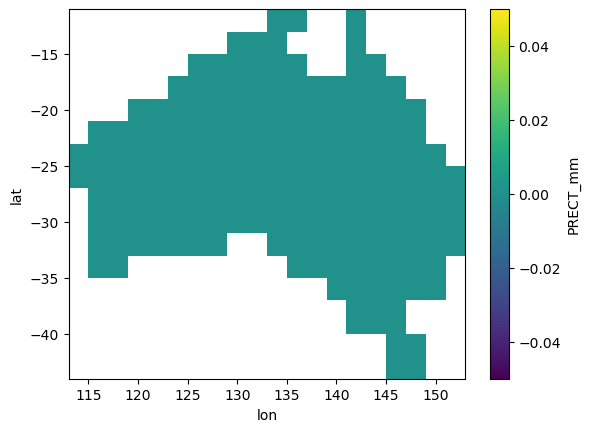

In [95]:
(ipsl_precip_hist_annual_aus_rg.PRECT_mm.mean(dim='year') - ipsl_precip_hist_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

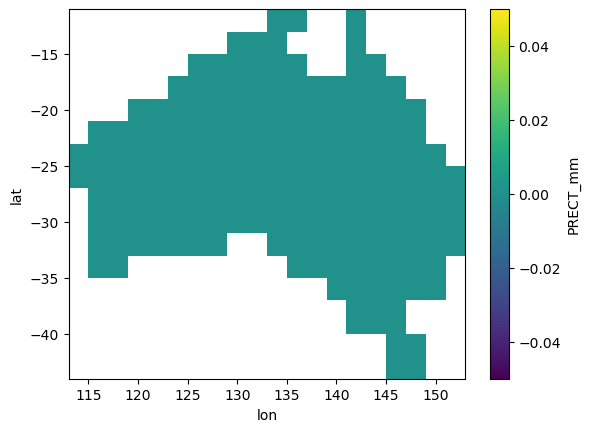

In [98]:
(miroc_precip_hist_annual_aus_rg.PRECT_mm.mean(dim='year') - miroc_precip_hist_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

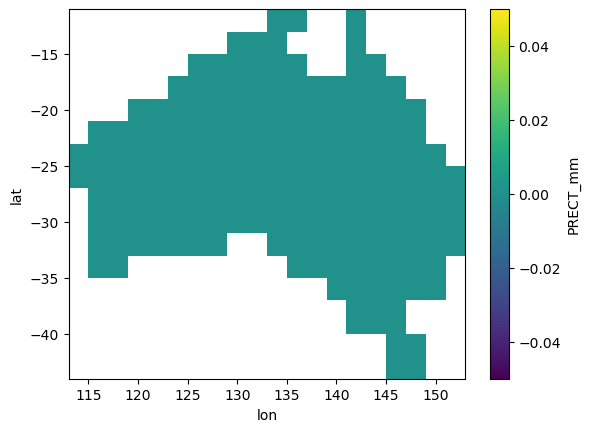

In [99]:
(mpi_precip_hist_annual_aus_rg.PRECT_mm.mean(dim='year') - mpi_precip_hist_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()

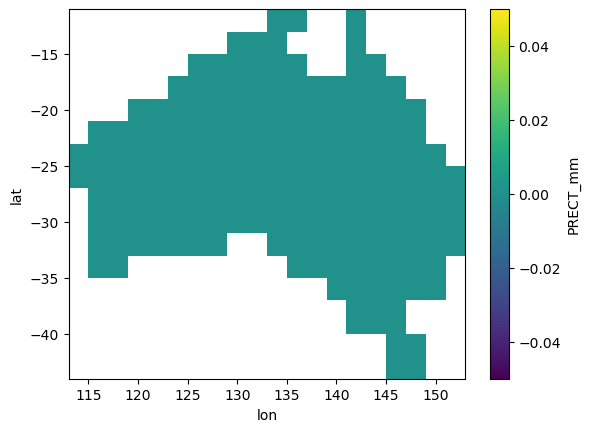

In [100]:
(mri_precip_hist_annual_aus_rg.PRECT_mm.mean(dim='year') - mri_precip_hist_annual_aus_rg_old.PRECT_mm.mean(dim='year')).plot()